## Load sample data

In [1]:
import tensorflow as tf
# disable warnings and enhance performance
tf.compat.v1.disable_eager_execution()  

import json
with open('qm9_sample.json', 'r') as f:
    data = json.load(f)

2024-04-22 06:26:32.866618: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/lib64
2024-04-22 06:26:32.866649: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Process train_structures and train_targets

In [3]:
from pymatgen.core import Molecule

qm9_ids = list(data.keys())

molecules = [Molecule.from_dict(data[i]['molecule']) for i in qm9_ids]  # this gives a list of pymatgen Molecule

structures = molecules
targets = [data[i]['property']['U0'] for i in qm9_ids]  # We are training U0 here


## Data splits

In reality, use train-val-test splits. Validation split can be used to select hyperparameters (e.g., epochs)

In [4]:
train_structures = structures[:80]
test_structures = structures[80:]
train_targets = targets[:80]
test_targets = targets[80:]

## Construct megnet models

In [5]:
from megnet.models import MEGNetModel
from megnet.data.graph import GaussianDistance
from megnet.data.crystal import CrystalGraph
from megnet.utils.preprocessing import StandardScaler
import numpy as np

In [6]:
gc = CrystalGraph(bond_converter=GaussianDistance(
    np.linspace(0, 5, 100), 0.5), cutoff=4)
model = MEGNetModel(100, 2, graph_converter=gc)

### Scale targets to train per atom quantity 

In [7]:
INTENSIVE = False # U0 is an extensive quantity
scaler = StandardScaler.from_training_data(train_structures, train_targets, is_intensive=INTENSIVE)
model.target_scaler = scaler

## Train the model!

In [8]:
model.train(train_structures, train_targets, epochs=10, verbose=2)  # In reality, use epochs>1000

Epoch 1/10


2024-04-22 06:27:32.282007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/lib64
2024-04-22 06:27:32.282095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/lib64
2024-04-22 06:27:32.282139: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/lib64
2024-04-22 06:27:32.282182: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Cou

1/1 - 8s - loss: 0.9999 - 8s/epoch - 8s/step
Epoch 2/10
1/1 - 0s - loss: 0.9991 - 173ms/epoch - 173ms/step
Epoch 3/10
1/1 - 0s - loss: 0.9967 - 181ms/epoch - 181ms/step
Epoch 4/10
1/1 - 0s - loss: 0.9952 - 178ms/epoch - 178ms/step
Epoch 5/10
1/1 - 0s - loss: 0.9935 - 170ms/epoch - 170ms/step
Epoch 6/10
1/1 - 0s - loss: 0.9910 - 166ms/epoch - 166ms/step
Epoch 7/10
1/1 - 0s - loss: 0.9883 - 165ms/epoch - 165ms/step
Epoch 8/10
1/1 - 0s - loss: 0.9854 - 169ms/epoch - 169ms/step
Epoch 9/10
1/1 - 0s - loss: 0.9814 - 183ms/epoch - 183ms/step
Epoch 10/10
1/1 - 0s - loss: 0.9762 - 173ms/epoch - 173ms/step


## Predict test data

In [9]:
predicted_tests = []
for i in test_structures:
    predicted_tests.append(model.predict_structure(i).ravel()[0])

/home/shibuM/anaconda3/envs/megnet/lib/python3.10/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Text(0, 0.5, 'Predicted $U_0$ (eV)')

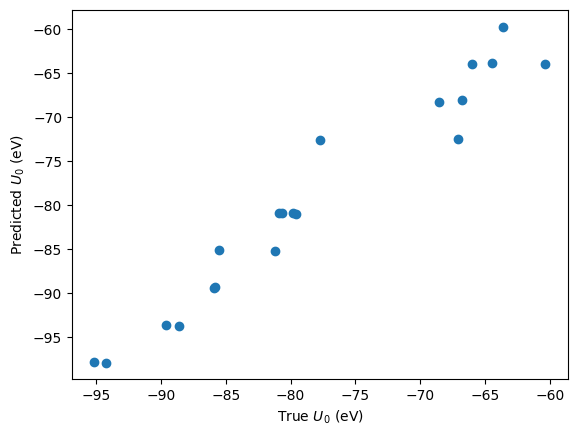

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(test_targets, predicted_tests, 'o')
plt.xlabel('True $U_0$ (eV)')
plt.ylabel('Predicted $U_0$ (eV)')

Results seem to be good considering that we are using 80 data points to train the model!